In [52]:
# set parameters
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import plotly.graph_objects as go
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:,.2f}'.format

METADATA = {'Contributor': 'T. Dunn', 'Date': '2021-12-27'}
FSIZE = [5,4]
FDPI = 100
SAVEFIGS = False
SAVETABS = False

In [15]:
# construct book dataframe
dfB = pd.read_csv('../../assets/data/books.csv')
dfB = dfB.astype({
    'Book': 'category', 
    'Acronym': 'category',
    'Date': 'datetime64',
    'Type': 'category'})
dfB.set_index('Acronym', inplace=True)
dfB

,Book,Date,Type
Acronym,,,
BGDiA,Baulder's Gate: Descent Into Avernus,2019-09-17,Adventure
CM,Candlekeep Mysteries,2021-03-16,Adventure
CRCotN,Critical Role: Call of the Netherdeep,2022-03-15,Adventure
CoS,Curse of Strahd,2016-03-16,Adventure
DSotDQ,Dragonlance: Shadow of the Dragon Queen,2022-12-06,Adventure
ERftLW,Eberron: Rising from the Last War,2019-11-19,Source
EGtW,Explorer's Guide to Wildmount,2020-03-07,Source
FToD,Fizban's Treasury of Dragons,2021-10-26,Source
GoS,Ghosts of Saltmarsh,2019-05-21,Adventure


In [16]:
# define functions
def find_nearest_loc(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def find_nearest_CR(CRs, array, value):
    idx = find_nearest_loc(array, value)
    CRs = np.asarray(CRs)
    return CRs[idx]

def effective_DPR_exp(DPR, AB):
    return np.power(0.6,  0.5)*DPR*np.power(1 + 0.05/0.6, AB - 3)

def effective_HP_exp(HP, AC):
    return np.power(0.6, -0.5)*HP*np.power(1 + 0.05/0.6, AC - 13)

def effective_XP_exp(HP, AC, DPR, AB):
    return 0.25*HP*DPR*np.power(1 + 0.05/0.6, AC + AB - 16)

def effective_DPR_linear(DPR, AB):
    return np.power(0.6,  0.5)*DPR*(1 + (0.05/0.6)*(AB - 3))

def effective_HP_linear(HP, AC):
    return np.power(0.6, -0.5)*HP*(1 + (0.05/0.6)*(AC - 13))

def effective_XP_linear(HP, AC, DPR, AB):
    return 0.25*HP*DPR*(1 + (0.05/0.6)*(AC + AB - 16))
    
def defensive_CR(df, HP, AC):
    n = df.shape[0]
    id = find_nearest_loc(df['HP Mean'], HP)
    CR_t = df.index[id]
    AC_t = df['AC'].loc[CR_t]
    id = int(max(0, min(n - 1, id + np.fix(0.5*(AC - AC_t)))))
    CR = df.index[id]
    return CR

def offensive_CR(df, DPR, AB):
    n = df.shape[0]
    id = find_nearest_loc(df['DPR Mean'], DPR)
    CR_t = df.index[id]
    AB_t = df['AB'].loc[CR_t]
    id = int(max(0, min(n - 1, id + np.fix(0.5*(AB - AB_t)))))
    CR = df.index[id]
    return CR
    
def rsquared(y, yf):
    y = np.asarray(y)
    yf = np.asarray(yf)
    ybar = np.mean(y)
    SStot = np.sum(np.power(np.subtract(y, ybar), 2))
    SSres = np.sum(np.power(y - yf, 2))
    return 1 - SSres/SStot

In [17]:
from scipy.interpolate import interp1d

# import data
dfD = pd.read_csv('dmg-targets-cr-and-xp.csv') # 'CR','PB','XP','AC','HP Mean','AB','DPR Mean'
dfD['eHP Mean']  = dfD.apply(lambda row: effective_HP_linear(row['HP Mean'], row['AC']), axis=1)
dfD['eDPR Mean'] = dfD.apply(lambda row: effective_DPR_linear(row['DPR Mean'], row['AB']), axis=1)
dfD['eXP Mean'] = dfD.apply(lambda row: effective_XP_linear(row['HP Mean'], row['AC'], row['DPR Mean'], row['AB']), axis=1)
dfD.set_index('CR', inplace=True)

xp2cr  = interp1d(dfD['eXP Mean'], dfD.index, kind='cubic', fill_value=(0.0,30.0), bounds_error=False)
hp2cr  = interp1d(dfD['eHP Mean'], dfD.index, kind='cubic', fill_value=(0.0,30.0), bounds_error=False)
dpr2cr = interp1d(dfD['eDPR Mean'], dfD.index, kind='cubic', fill_value=(0.0,30.0), bounds_error=False)

df0 = pd.read_csv('monster-cr-and-xp.csv')  # 'Monster','Book','Page','Type','Category','Legendary','CR','PB','XP',
                                            # 'HP','AC','adj HP','adj AC',
                                            # 'AB','adj AB','DPR', 'adj DPR'

df0 = df0.astype({'Book': 'category', 'Category': 'category', 'Legendary': 'category', 'Type': 'category'})

df0['eHP']  = df0.apply(lambda row: effective_HP_linear(row['adj HP'], row['adj AC']), axis=1)
df0['eDPR'] = df0.apply(lambda row: effective_DPR_linear(row['adj DPR'], row['adj AB']), axis=1)
df0['eXP']  = df0.apply(lambda row: effective_XP_linear(row['adj HP'], row['adj AC'], row['adj DPR'], row['adj AB']), axis=1)
#df0['eCR']  = df0.apply(lambda row: find_nearest_CR(dfD.index, dfD['eXP Mean'], row['eXP']), axis=1)
df0['D-eCR']  = df0.apply(lambda row: float(hp2cr(row['eHP'])), axis=1)
df0['O-eCR']  = df0.apply(lambda row: float(dpr2cr(row['eDPR'])), axis=1)
df0['eCR']  = df0.apply(lambda row: float(xp2cr(row['eXP'])), axis=1)
df0['eHP Ratio'] = df0.apply(lambda row: row['eHP']/dfD.loc[row['CR'], 'eHP Mean'], axis=1)
df0['eDPR Ratio'] = df0.apply(lambda row: row['eDPR']/dfD.loc[row['CR'], 'eDPR Mean'], axis=1)
df0['eCR Delta'] = df0['eCR'] - df0['CR']
df0['eXP Ratio'] = df0['eXP'] / df0['XP']
df0['eXP Skew'] = (df0['eDPR Ratio'] - df0['eHP Ratio'])/(df0['eDPR Ratio'] + df0['eHP Ratio'])

df0['D-CR DMG'] = df0.apply(lambda row: defensive_CR(dfD, row['adj HP'], row['adj AC']), axis=1)
df0['O-CR DMG'] = df0.apply(lambda row: offensive_CR(dfD, row['adj DPR'], row['adj AB']), axis=1)
df0['C-CR DMG'] = df0.apply(lambda row: find_nearest_CR(dfD.index, dfD.index, 0.5*(row['D-CR DMG'] + row['O-CR DMG'])), axis=1)
df0['C-CR DMG Delta'] = df0['C-CR DMG'] - df0['CR']
df0['XP DMG'] = df0.apply(lambda row: dfD.loc[row['C-CR DMG'], 'XP'], axis=1)
df0['XP DMG Ratio'] = df0['XP DMG'] / df0['XP']
#df0['C-CR DMG'] = 0.5*(df0['D-CR DMG'] + df0['O-CR DMG'])

df0['Date'] = df0.apply(lambda row: dfB.loc[row['Book'], 'Date'], axis=1)
df0['Book Type'] = df0.apply(lambda row: dfB.loc[row['Book'], 'Type'], axis=1)

len(df0.index.tolist())
print('Includes {} monsters in database'.format(len(df0.index.to_list())))

Includes 1781 monsters in database


In [18]:
# Setup template and html config for plotly figures.
TFB_TEMPLATE = dict(
    layout=go.Layout(
        template='plotly_white',
        autosize=True, # must be True to auto-scale when resizing
        margin=dict(l=50, r=25, b=80, t=40, pad=4),
        font=dict(
            family='sans-serif',
            size=14
        ),
        hovermode='closest',
        xaxis=dict(
            autorange=False,
            automargin=True,
            showline=True,
            linecolor='#444',
            linewidth=2,
            mirror=True,
            ticks='outside',
            minor=dict(ticks='outside'),
            zeroline=False,
        ),
        yaxis=dict(
            autorange=False,
            automargin=True,
            showline=True,
            linecolor='#444',
            linewidth=2,
            mirror=True,
            ticks='outside',
            minor=dict(ticks='outside'),
            zeroline=False,
        ),
        legend=dict(
            bordercolor='Black',
            borderwidth=1,
            font_size=14,
            tracegroupgap=5,
            orientation='h',
        )
    )
)

TFB_CONFIG = {
    'responsive': True, # must be True to auto-scale when resizing
    'autosizable': False, # doesn't impact auto rescaling
    'showAxisDragHandles': False,
    'displaylogo': False,
    'displayModeBar': 'hover',
    'modeBarButtonsToRemove': [
        'select2d',
        'lasso2d',
        'zoom2d',
        'zoomIn2d',
        'zoomOut2d',
        'pan2d',
        'autoScale2d',
        'hoverClosestCartesian',
        'hoverCompareCartesian',
        'toggleSpikelines',
        'resetScale2d',
    ],
    'toImageButtonOptions': {
        'format': 'png', # one of png, svg, jpeg, webp
        'filename': 'tfb-plot',
        'height': 450,
        'width': 600,
        'scale': 2
    },
}


In [74]:
# plot eXP ratio vs time. Split data by book type.
from datetime import date
import plotly.express as px
from bs4 import BeautifulSoup

groups = {
    'adventure modules - normal': {
        'Legendary': ['N'],
        'marker': dict(
            size=10, 
            color='rgba(0,0,0,0.0)', 
            line=dict(color='rgba(31,119,180,1.0)', width=2)
        )
    },
    'adventure modules - legendary': {
        'Legendary': ['L','LL'],
        'marker': dict(
            size=10, 
            color='rgba(31,119,180,1.0)', 
            line=dict(color='rgba(31,119,180,1.0)', width=2)
        )
    }
}

# summarize the current dataset
df1 = df0[df0['CR'].between(1,30) 
    & df0['Legendary'].isin(['N','L','LL'])
    & df0['Book Type'].isin(['Adventure'])]
df1['group'] = df1.apply(lambda row: 'adventure modules - normal' if row['Legendary'] == 'N' else 'adventure modules - legendary', axis=1)

group_columns = ['Date','group','Book']
date_range = [date(2014, 1, 1), date.today()]

# plot results
fig = go.Figure()

for g in groups:
    group = groups[g]
    mask = (df1['Legendary'].isin(group['Legendary']))
    dfG = df1[mask].groupby(group_columns).size().to_frame('Total').reset_index()
    dfG['eXP Ratio Mean'] = df1[mask].groupby(group_columns).mean().reset_index()['eXP Ratio']
    dfG['eXP Ratio Std Dev'] = df1[mask].groupby(group_columns).std().reset_index()['eXP Ratio']
    dfG = dfG.sort_values(by=['Date'])
    dfG = dfG[dfG['Total'].ge(1)]
    
    fig.add_trace(go.Scatter(
        x=dfG['Date'], 
        y=dfG['eXP Ratio Mean'],
        mode='markers',
        name=g,
    ))

    fig.update_traces(
        selector=dict(name=g),
        customdata = np.stack((dfG['Book'], dfG['Total']), axis=-1),
        hovertemplate = '<b>%{customdata[0]}</b><br>'
            + 'Date: %{x}<br>'
            + 'XP ratio: %{y:.2f}<br>'
            + 'Monsters: %{customdata[1]:.0f}'
            + '<extra></extra>',
        marker=group['marker'],
    )

fig.add_trace(go.Scatter(
    x=date_range, 
    y=[1, 1],
    mode='lines', 
    line=dict(color='black', dash='dash'),
    showlegend=False,
    hoverinfo='skip'
))

# save large format figure
fig.update_layout(
    template=TFB_TEMPLATE,
    hoverlabel=dict(
        bgcolor='white',
    ),
    xaxis=dict(
        title_text='publication year',
        range=date_range,
    ),
    yaxis=dict(
        title_text='calculated XP ratio',
        range=[0, 4],
        tick0=0, dtick=0.5,
        tickformat='.1f',
        minor=dict(tick0=0, dtick=0.25),
    ),
    legend=dict(
        yanchor='top',  y=0.99,
        xanchor='right', x=0.99,
        orientation='v',
    ),
)

fig.show(config=TFB_CONFIG)
if SAVEFIGS:
    file_name = f'./fig-exp-ratio-mean-vs-time-adventure-modules-large.html'
    fig.write_html(
        file_name, 
        include_plotlyjs=False, 
        full_html=False, 
        config=TFB_CONFIG
    )
    # add style to figure
    with open(file_name, 'r') as fin:
        fig_soup = BeautifulSoup(fin, 'html.parser')

    fig_soup.div['class'] = 'plotly-div-large'
    fig_soup.div['style'] = 'width:800px; min-width:50%; max-width:100%'
    with open(file_name, 'wb') as fout:
        fout.write(fig_soup.prettify('utf-8'))

# save small format figure
fig.update_traces(marker=dict(size=6))
fig.update_layout(font=dict(size=10), legend=dict(font=dict(size=10)))

fig.show(config=TFB_CONFIG)
if SAVEFIGS:
    file_name = f'./fig-exp-ratio-mean-vs-time-adventure-modules-small.html'
    fig.write_html(
        file_name, 
        include_plotlyjs=False, 
        full_html=False, 
        config=TFB_CONFIG
    )
    # add style to figure
    with open(file_name, 'r') as fin:
        fig_soup = BeautifulSoup(fin, 'html.parser')

    fig_soup.div['class'] = 'plotly-div-small'
    #fig_soup.div['style'] = 'hight:800px; min-width:50%; max-width:100%'
    fig_soup.div['style'] = 'aspect-ratio: 600/500;'
    with open(file_name, 'wb') as fout:
        fout.write(fig_soup.prettify('utf-8'))

In [22]:
# summary table of legendary monsters from early adventure books
df1 = df0[df0['CR'].between(1,30) & df0['Book Type'].isin(['Adventure']) & df0['Date'].lt('2018-1-1') & df0['Legendary'].isin(['L','LL'])]
df1 = df1.sort_values(by=['Date','Monster'])
dfG = df1[['Date','Book','Monster']]
dfG['Monsters'] = df1.groupby(['Book'])['Monster'].transform(lambda x: ', '.join(x))
dfG = dfG[['Book','Monsters']].drop_duplicates()

if SAVETABS: dfG.to_html('./early-adventure-legendary-monsters.html', index=False, classes='center', float_format='{:,.2f}'.format, border=0)

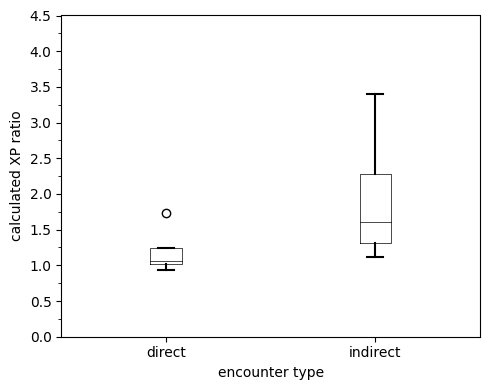

In [23]:
# plot the range of eXP values for legendary monsters encountered directly and indirectly
directMonsters = ['Rezmir','Yestabrod','Tarul Var','Atropal']
df1 = df0[df0['CR'].between(1,30) & df0['Book Type'].isin(['Adventure']) & df0['Date'].lt('2018-1-1') & df0['Legendary'].isin(['L','LL'])]
df1['Encounter Type'] = 'indirect'
df1.loc[df1['Monster'].isin(directMonsters), 'Encounter Type'] = 'direct'
df1.sort_values(by=['Encounter Type','eXP Ratio'], inplace=True)

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes(ylabel='calculated XP ratio', xlabel='encounter type', ylim=[0,4.5])
bp = ax.boxplot(tuple(df1[df1['Encounter Type'].isin([x])]['eXP Ratio'] for x in df1['Encounter Type'].unique()), 
    labels=df1['Encounter Type'].unique(), patch_artist=False,
    showmeans=False, vert=True, showfliers=True,
    medianprops={'color': 'k', 'linewidth': 0.5},
    #boxprops={'facecolor': 'C0', 'edgecolor': 'white', 'linewidth': 0.5},
    boxprops={'color': 'k', 'linewidth': 0.5},
    whiskerprops={'color': 'k', 'linewidth': 1.5},
    capprops={'color': 'k', 'linewidth': 1.5})

ax.yaxis.set_major_locator(MultipleLocator(0.5))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_minor_locator(MultipleLocator(0.25))

if SAVEFIGS: plt.savefig('exp-ratio-vs-encounter-type.svg', metadata=METADATA)

In [71]:
# list of monsters published in two different books
df1 = df0[df0['CR'].between(1,30) & df0['Legendary'].isin(['LL'])]
dfG = df1.groupby(['Monster','Book']).size().to_frame('Total').reset_index()
dfG = dfG[dfG['Total'].gt(0)]
dfG = dfG.groupby(['Monster']).size().to_frame('Total').reset_index()
dfG = dfG[dfG['Total'].gt(2)]
dupMonsters = dfG['Monster'].tolist()

df1 = df1[df1['Monster'].isin(dupMonsters)]

#books = list(df1['Book'].unique())
books = ['OotA', 'MToF', 'MPMotM']
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
markers = [
    dict(
        color='#1f77b4', 
        line=dict(color='#1f77b4', width=2),
        size=10,
        symbol='circle',
    ),
    dict(
        color='rgba(0,0,0,0.0)', 
        line=dict(color='#1f77b4', width=2),
        size=10, 
        symbol='circle',
    ),
    dict(
        color='rgba(0,0,0,0.0)', 
        line=dict(color='#1f77b4', width=2),
        size=10, 
        symbol='triangle-up',
    )
]

# create figure
fig = go.Figure()

for book, color, marker in zip(books, colors, markers):
    data = df1[df1['Book'].isin([book])]
    xpr_mean = np.mean(data['eXP Ratio'])
    xpr_std = np.std(data['eXP Ratio'])
    print(f'{book}: {xpr_mean:.2f} ({xpr_std:.2f})')
    text = [f'{x:.0f}' for x in data['CR'].to_list()]
    fig.add_trace(go.Scatter(
        x=data['Monster'], 
        y=data['eXP Ratio'],
        mode='markers',
        marker=marker,
        name=book,
        text=text,
        hovertemplate=
            f'<b>Book:</b> {book}<br>'+
            '<b>Monster:</b> %{x}<br>'+
            '<b>CR:</b> %{text}<br>'+
            '<b>XP ratio:</b> %{y:.2f}'+
            '<extra></extra>'
    ))

# save large format figure
fig.update_layout(
    template=TFB_TEMPLATE,
    xaxis=dict(
        range=[-0.5, len(dupMonsters)-0.5],
    ),
    yaxis=dict(
        title_text='calculated XP ratio',
        range=[0, 2.5],
        tick0=0, dtick=0.5,
        minor=dict(tick0=0, dtick=0.25),
    ),
    legend=dict(
        yanchor='top',  y=0.99,
        xanchor='right', x=0.99,
        orientation='v',
    ),
)

fig.show(config=TFB_CONFIG)
if SAVEFIGS:
    file_name = f'./fig-exp-ratio-vs-monster-demon-lords-large.html'
    fig.write_html(
        file_name, 
        include_plotlyjs=False, 
        full_html=False, 
        config=TFB_CONFIG
    )
    # add style to figure
    with open(file_name, 'r') as fin:
        fig_soup = BeautifulSoup(fin, 'html.parser')

    fig_soup.div['class'] = 'plotly-div-large'
    #fig_soup.div['style'] = 'width:800px; min-width:50%; max-width:100%'
    with open(file_name, 'wb') as fout:
        fout.write(fig_soup.prettify('utf-8'))

# save small format figure
fig.update_traces(marker=dict(size=6))
fig.update_layout(font=dict(size=10), legend=dict(font=dict(size=10)))

fig.show(config=TFB_CONFIG)
if SAVEFIGS:
    file_name = f'./fig-exp-ratio-vs-monster-demon-lords-small.html'
    fig.write_html(
        file_name, 
        include_plotlyjs=False, 
        full_html=False, 
        config=TFB_CONFIG
    )
    # add style to figure
    with open(file_name, 'r') as fin:
        fig_soup = BeautifulSoup(fin, 'html.parser')

    fig_soup.div['class'] = 'plotly-div-small'
    fig_soup.div['style'] = 'aspect-ratio: 600/500;'
    with open(file_name, 'wb') as fout:
        fout.write(fig_soup.prettify('utf-8'))

OotA: 1.40 (0.31)
MToF: 1.04 (0.19)
MPMotM: 1.03 (0.15)


In [70]:
# plot eXP ratio vs time. Split data by book type.
from datetime import date
import plotly.express as px
from bs4 import BeautifulSoup

groups = {
    'adventure modules - normal': {
        'Legendary': ['N'],
        'marker': dict(
            size=10, 
            color='rgba(0,0,0,0.0)', 
            line=dict(color='#ff7f0e', width=2)
        )
    },
    'adventure modules - legendary': {
        'Legendary': ['L','LL'],
        'marker': dict(
            size=10, 
            color='#ff7f0e', 
            line=dict(color='#ff7f0e', width=2)
        )
    }
}

# summarize the current dataset
df1 = df0[df0['CR'].between(1,30) 
    & df0['Legendary'].isin(['N','L','LL'])
    & df0['Book Type'].isin(['Source'])]
df1['group'] = df1.apply(lambda row: 'source books - normal' if row['Legendary'] == 'N' else 'source books - legendary', axis=1)

group_columns = ['Date','group','Book']
date_range = [date(2014, 1, 1), date.today()]

# plot results
fig = go.Figure()

for g in groups:
    group = groups[g]
    mask = (df1['Legendary'].isin(group['Legendary']))
    dfG = df1[mask].groupby(group_columns).size().to_frame('Total').reset_index()
    dfG['eXP Ratio Mean'] = df1[mask].groupby(group_columns).mean().reset_index()['eXP Ratio']
    dfG['eXP Ratio Std Dev'] = df1[mask].groupby(group_columns).std().reset_index()['eXP Ratio']
    dfG = dfG.sort_values(by=['Date'])
    dfG = dfG[dfG['Total'].ge(1)]
    
    fig.add_trace(go.Scatter(
        x=dfG['Date'], 
        y=dfG['eXP Ratio Mean'],
        mode='markers',
        name=g,
    ))

    fig.update_traces(
        selector=dict(name=g),
        customdata = np.stack((dfG['Book'], dfG['Total']), axis=-1),
        hovertemplate = '<b>%{customdata[0]}</b><br>'
            + 'Date: %{x}<br>'
            + 'XP ratio: %{y:.2f}<br>'
            + 'Monsters: %{customdata[1]:.0f}'
            + '<extra></extra>',
        marker=group['marker'],
    )

fig.add_trace(go.Scatter(
    x=date_range, 
    y=[1, 1],
    mode='lines', 
    line=dict(color='black', dash='dash'),
    showlegend=False,
    hoverinfo='skip'
))

# save large format figure
fig.update_layout(
    template=TFB_TEMPLATE,
    hoverlabel=dict(
        bgcolor='white',
    ),
    xaxis=dict(
        title_text='publication year',
        range=date_range,
    ),
    yaxis=dict(
        title_text='calculated XP ratio',
        range=[0, 2],
        tick0=0, dtick=0.5,
        tickformat='.1f',
        minor=dict(tick0=0, dtick=0.25),
    ),
    legend=dict(
        yanchor='top',  y=0.99,
        xanchor='right', x=0.99,
        orientation='v',
    ),
)

fig.show(config=TFB_CONFIG)
if SAVEFIGS:
    file_name = f'./fig-exp-ratio-mean-vs-time-source-books-large.html'
    fig.write_html(
        file_name, 
        include_plotlyjs=False, 
        full_html=False, 
        config=TFB_CONFIG
    )
    # add style to figure
    with open(file_name, 'r') as fin:
        fig_soup = BeautifulSoup(fin, 'html.parser')

    fig_soup.div['class'] = 'plotly-div-large'
    fig_soup.div['style'] = 'width:800px; min-width:50%; max-width:100%'
    with open(file_name, 'wb') as fout:
        fout.write(fig_soup.prettify('utf-8'))

# save small format figure
fig.update_traces(marker=dict(size=6))
fig.update_layout(font=dict(size=10), legend=dict(font=dict(size=10)))

fig.show(config=TFB_CONFIG)
if SAVEFIGS:
    file_name = f'./fig-exp-ratio-mean-vs-time-source-books-small.html'
    fig.write_html(
        file_name, 
        include_plotlyjs=False, 
        full_html=False, 
        config=TFB_CONFIG
    )
    # add style to figure
    with open(file_name, 'r') as fin:
        fig_soup = BeautifulSoup(fin, 'html.parser')

    fig_soup.div['class'] = 'plotly-div-small'
    #fig_soup.div['style'] = 'hight:800px; min-width:50%; max-width:100%'
    fig_soup.div['style'] = 'aspect-ratio: 600/500;'
    with open(file_name, 'wb') as fout:
        fout.write(fig_soup.prettify('utf-8'))

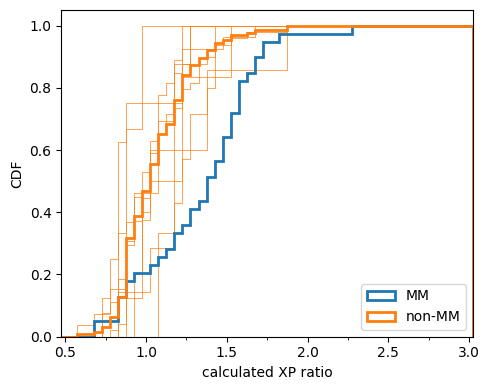

In [26]:
# plot CDF of eXP Ratio for different source books
plotColumn = 'eXP Ratio'
groups = {
    'MM': {'Book': ['MM'], 'color': colors[0]},
    'non-MM': {'Book': ['VGtM','MToF','GGtR','ERftLW','EGtW','MOoT','VRGtR','FToD','SaCoC'], 'color': colors[1]}
}

df1 = df0[df0['CR'].between(1,30) & df0['Book Type'].isin(['Source']) & df0['Legendary'].isin(['L','LL'])]
df1['Book'] = df1['Book'].cat.remove_unused_categories()

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

rMin = 0.5; rMax = 3; rDel = 0.05
rLims = [rMin - rDel/2, rMax + rDel/2]
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes()
for b in groups['non-MM']['Book']:
    ax.hist(df1[df1['Book'].isin([b])][plotColumn], rRange, density=True, cumulative=True, histtype='step', 
        linewidth=0.5, edgecolor=groups['non-MM']['color'])

for g in groups:
    ax.hist(df1[df1['Book'].isin(groups[g]['Book'])][plotColumn], rRange, density=True, cumulative=True, histtype='step', label=g, 
        linewidth=2, edgecolor=groups[g]['color'])

ax.set(xlim=rLims, xlabel='calculated XP ratio', ylabel='CDF')
ax.legend(loc='lower right')

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

if SAVEFIGS: plt.savefig('exp-ratio-cdf-mm-vs-source-books.svg', metadata=METADATA)

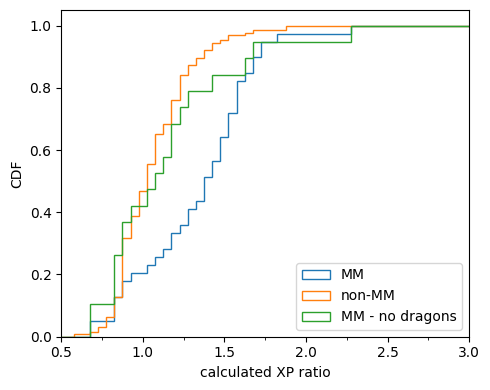

In [27]:
# summarize the current dataset
df1 = df0[df0['CR'].between(1,30) 
    & df0['Book Type'].isin(['Source']) 
    & df0['Legendary'].isin(['L','LL'])]

col = 'eXP Ratio'

groups = {
    'MM': {'Book': ['MM'], 'Exclude Type': []},
    'non-MM': {'Book': ['VGtM','MToF','GGtR','ERftLW','EGtW','MOoT','VRGtR','FToD','SaCoC'], 'Exclude Type': []},
    'MM - no dragons': {'Book': ['MM'], 'Exclude Type': ['dragon']},
}

rMin = 0.5; rMax = 3; rDel = 0.05
rLims = [rMin - rDel/2, rMax + rDel/2]
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)

fig = plt.figure(figsize=FSIZE, dpi=FDPI, tight_layout=True)
ax = plt.axes()

for g in groups:
    ax.hist(df1[df1['Book'].isin(groups[g]['Book']) & ~df1['Type'].isin(groups[g]['Exclude Type'])]['eXP Ratio'],
        rRange, density=True, cumulative=True, histtype='step', linewidth=1, label=g)

ax.set(xlim=[0.5,3.0], xlabel='calculated XP ratio', ylabel='CDF')
ax.legend(loc='lower right')

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

if SAVEFIGS: plt.savefig('exp-ratio-cdf-mm-vs-source-books-no-dragons.svg', metadata=METADATA)

In [68]:
# dragons in the MM vs non-dragons
from datetime import date
import plotly.express as px
from bs4 import BeautifulSoup

# summarize the current dataset
df1 = df0[df0['Book'].isin(['MM']) & df0['Legendary'].isin(['L','LL'])]
indx = df1['Type'].isin(['dragon'])

# plot results
fig = go.Figure()

dft = df1[~indx]
fig.add_trace(go.Scatter(
    x=dft['CR'], 
    y=dft['eXP Ratio'],
    mode='markers',
    name='non-dragons',
    marker=dict(
        size=10, 
        color='#1f77b4', 
        line=dict(color='#1f77b4', width=2)
    ),
    customdata = np.stack((dft['Monster'], dft['Book']), axis=-1),
    hovertemplate = '<b>%{customdata[0]}</b><br>'
                  + 'Book: %{customdata[1]}<br>'
                  + 'CR: %{x:.0f}<br>'
                  + 'XP ratio: %{y:.2f}<br>'
                  + '<extra></extra>',
))

dft = df1[indx]
fig.add_trace(go.Scatter(
    x=dft['CR'], 
    y=dft['eXP Ratio'],
    mode='markers',
    name='dragons',
    marker=dict(
        size=10, 
        color='#ff7f0e', 
        line=dict(color='#ff7f0e', width=2)
    ),
    customdata = np.stack((dft['Monster'], dft['Book']), axis=-1),
    hovertemplate = '<b>%{customdata[0]}</b><br>'
                  + 'Book: %{customdata[1]}<br>'
                  + 'CR: %{x:.0f}<br>'
                  + 'XP ratio: %{y:.2f}<br>'
                  + '<extra></extra>',
))

fig.add_trace(go.Scatter(
    x=[10,30], 
    y=[1, 1],
    mode='lines', 
    line=dict(color='black', dash='dash'),
    showlegend=False,
    hoverinfo='skip'
))

# save large format figure
fig.update_layout(
    template=TFB_TEMPLATE,
    hoverlabel=dict(
        bgcolor='white',
    ),
    xaxis=dict(
        title_text='CR',
        range=[9.5,30.5],
    ),
    yaxis=dict(
        title_text='calculated XP ratio',
        range=[0, 3],
        tick0=0, dtick=0.5,
        tickformat='.1f',
        minor=dict(tick0=0, dtick=0.25),
    ),
    legend=dict(
        yanchor='top',  y=0.99,
        xanchor='left', x=0.01,
        orientation='v',
    ),
)

fig.show(config=TFB_CONFIG)
if SAVEFIGS:
    file_name = f'./fig-exp-ratio-vs-cr-mm-type-dragon-large.html'
    fig.write_html(
        file_name, 
        include_plotlyjs=False, 
        full_html=False, 
        config=TFB_CONFIG
    )
    # add style to figure
    with open(file_name, 'r') as fin:
        fig_soup = BeautifulSoup(fin, 'html.parser')

    fig_soup.div['class'] = 'plotly-div-large'
    #fig_soup.div['style'] = 'aspect-ratio: 600/500;'
    with open(file_name, 'wb') as fout:
        fout.write(fig_soup.prettify('utf-8'))

# save small format figure
fig.update_traces(marker=dict(size=6))
fig.update_layout(font=dict(size=10), legend=dict(font=dict(size=10)))

fig.show(config=TFB_CONFIG)
if SAVEFIGS:
    file_name = f'./fig-exp-ratio-vs-cr-mm-type-dragon-small.html'
    fig.write_html(
        file_name, 
        include_plotlyjs=False, 
        full_html=False, 
        config=TFB_CONFIG
    )
    # add style to figure
    with open(file_name, 'r') as fin:
        fig_soup = BeautifulSoup(fin, 'html.parser')

    fig_soup.div['class'] = 'plotly-div-small'
    fig_soup.div['style'] = 'aspect-ratio: 600/500;'
    with open(file_name, 'wb') as fout:
        fout.write(fig_soup.prettify('utf-8'))

In [69]:
# comparison between dragons published in the MM and those puliblished in FToD

# summarize the current dataset
df1 = df0[df0['CR'].between(1,30) & df0['Legendary'].isin(['L','LL']) & df0['Type'].isin(['dragon'])]

# plot results
fig = go.Figure()

dft = df1[df1['Book'].isin(['MM'])]
fig.add_trace(go.Scatter(
    x=dft['CR'], 
    y=dft['eXP Ratio'],
    mode='markers',
    name='MM',
    marker=dict(
        size=10, 
        color='#1f77b4', 
        line=dict(color='#1f77b4', width=2)
    ),
    customdata = np.stack((dft['Monster'], dft['Book']), axis=-1),
    hovertemplate = '<b>%{customdata[0]}</b><br>'
                  + 'Book: %{customdata[1]}<br>'
                  + 'CR: %{x:.0f}<br>'
                  + 'XP ratio: %{y:.2f}<br>'
                  + '<extra></extra>',
))

dft = df1[df1['Book'].isin(['FToD'])]
fig.add_trace(go.Scatter(
    x=dft['CR'], 
    y=dft['eXP Ratio'],
    mode='markers',
    name='FToD',
    marker=dict(
        size=10, 
        color='#ff7f0e', 
        line=dict(color='#ff7f0e', width=2)
    ),
    customdata = np.stack((dft['Monster'], dft['Book']), axis=-1),
    hovertemplate = '<b>%{customdata[0]}</b><br>'
                  + 'Book: %{customdata[1]}<br>'
                  + 'CR: %{x:.0f}<br>'
                  + 'XP ratio: %{y:.2f}<br>'
                  + '<extra></extra>',
))

fig.add_trace(go.Scatter(
    x=[10,30], 
    y=[1, 1],
    mode='lines', 
    line=dict(color='black', dash='dash'),
    showlegend=False,
    hoverinfo='skip'
))

# save large format figure
fig.update_layout(
    template=TFB_TEMPLATE,
    hoverlabel=dict(
        bgcolor='white',
    ),
    xaxis=dict(
        title_text='CR',
        range=[9.5,30.5],
    ),
    yaxis=dict(
        title_text='calculated XP ratio',
        range=[0, 2],
        tick0=0, dtick=0.5,
        tickformat='.1f',
        minor=dict(tick0=0, dtick=0.25),
    ),
    legend=dict(
        yanchor='top',  y=0.99,
        xanchor='right', x=0.99,
        orientation='v',
    ),
)

fig.show(config=TFB_CONFIG)
if SAVEFIGS:
    file_name = f'./fig-exp-ratio-vs-cr-mm-ftod-type-dragon-large.html'
    fig.write_html(
        file_name, 
        include_plotlyjs=False, 
        full_html=False, 
        config=TFB_CONFIG
    )
    # add style to figure
    with open(file_name, 'r') as fin:
        fig_soup = BeautifulSoup(fin, 'html.parser')

    fig_soup.div['class'] = 'plotly-div-large'
    #fig_soup.div['style'] = 'aspect-ratio: 600/500;'
    with open(file_name, 'wb') as fout:
        fout.write(fig_soup.prettify('utf-8'))

# save small format figure
fig.update_traces(marker=dict(size=6))
fig.update_layout(font=dict(size=10), legend=dict(font=dict(size=10)))

fig.show(config=TFB_CONFIG)
if SAVEFIGS:
    file_name = f'./fig-exp-ratio-vs-cr-mm-ftod-type-dragon-small.html'
    fig.write_html(
        file_name, 
        include_plotlyjs=False, 
        full_html=False, 
        config=TFB_CONFIG
    )
    # add style to figure
    with open(file_name, 'r') as fin:
        fig_soup = BeautifulSoup(fin, 'html.parser')

    fig_soup.div['class'] = 'plotly-div-small'
    fig_soup.div['style'] = 'aspect-ratio: 600/500;'
    with open(file_name, 'wb') as fout:
        fout.write(fig_soup.prettify('utf-8'))

In [30]:
df1 = df0[df0['CR'].between(1,30) & df0['Legendary'].isin(['L','LL']) & df0['Type'].isin(['dragon'])]
dfM = df1[df1['Book'].isin(['MM'])].mean()['eXP Ratio']
dfF = df1[df1['Book'].isin(['FToD'])].mean()['eXP Ratio']
dfF

<ipython-input-30-414a1a940976>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  dfM = df1[df1['Book'].isin(['MM'])].mean()['eXP Ratio']
<ipython-input-30-414a1a940976>:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  dfF = df1[df1['Book'].isin(['FToD'])].mean()['eXP Ratio']


1.0934828804047816

No handles with labels found to put in legend.


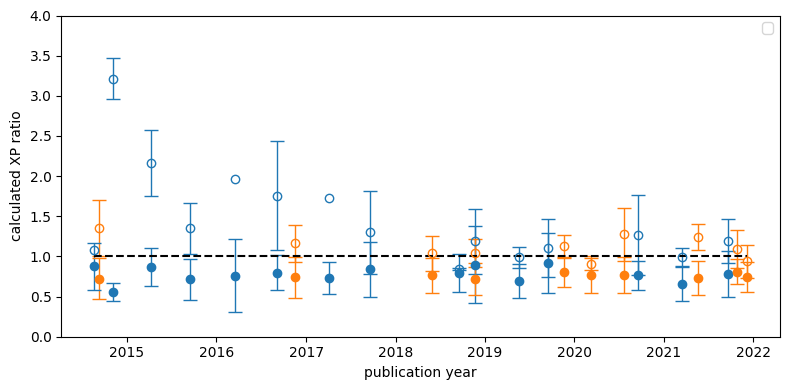

In [31]:
# plot eXP ratio vs time. Split data by book type.
col = 'eXP Ratio'
groupbyCol = 'Date'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
groups = {
    'adventure books - normal': {
        'Book Type': ['Adventure'],
        'Legendary': ['N'],
        'Edge Color': colors[0],
        'Face Color': colors[0],
        'Marker': 'o'
    },
    'adventure books - legendary': {
        'Book Type': ['Adventure'],
        'Legendary': ['L','LL'],
        'Edge Color': colors[0],
        'Face Color': 'none',
        'Marker': 'o'
    },
    'source books - normal': {
        'Book Type': ['Source'],
        'Legendary': ['N'],
        'Edge Color': colors[1],
        'Face Color': colors[1],
        'Marker': 'o'
    },
    'source books - legendary': {
        'Book Type': ['Source'],
        'Legendary': ['L','LL'],
        'Edge Color': colors[1],
        'Face Color': 'none',
        'Marker': 'o'
    }
}

# summarize the current dataset
df1 = df0[df0['CR'].between(1,30) & df0['Legendary'].isin(['N','L','LL'])]

# plot results
fig = plt.figure(figsize=[8,4], dpi=FDPI, tight_layout=True)
ax = plt.axes()

for g in groups:
    group = groups[g]
    mask = (df1['Book Type'].isin(group['Book Type']) & df1['Legendary'].isin(group['Legendary']))
    dfG = df1[mask].groupby(['Date']).size().to_frame('Total').reset_index()
    dfG['Mean'] = df1[mask].groupby(['Date']).mean().reset_index()[col]
    dfG['Std Dev'] = df1[mask].groupby(['Date']).std().reset_index()[col]
    dfG = dfG.sort_values(by=['Date'])
    dfG = dfG[dfG['Total'].ge(1)]
    ax.errorbar(x=dfG['Date'], y=dfG['Mean'], yerr=dfG['Std Dev'], 
        markeredgecolor=group['Edge Color'], markerfacecolor=group['Face Color'],
        fmt='o', elinewidth=1, capsize=5, ecolor=group['Edge Color'])

dateLims = [df1['Date'].min(),df1['Date'].max()]
ax.plot(dateLims, [1]*len(dateLims), '--', color='k')
ax.set(xlabel='publication year', ylabel='calculated XP ratio', ylim=[0,4])
ax.legend()

#if SAVEFIGS: plt.savefig('exp-ratio-mean-vs-time-by-book-type-and-legendary.svg', metadata=METADATA)

No handles with labels found to put in legend.


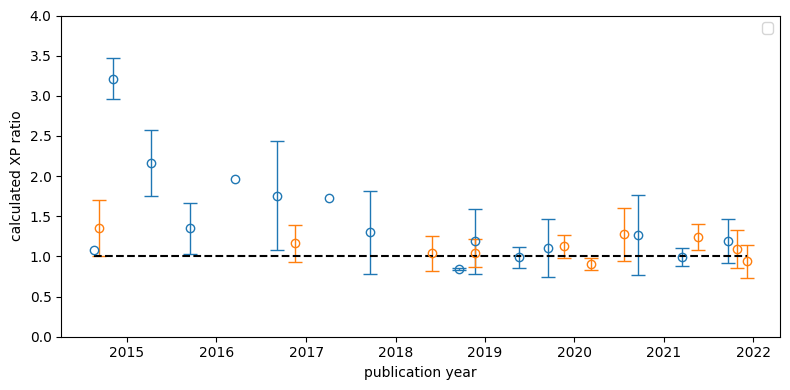

In [32]:
# plot eXP ratio vs time. Legendary monsters only.
col = 'eXP Ratio'
groupbyCol = 'Date'
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
groups = {
    'adventure books - legendary': {
        'Book Type': ['Adventure'],
        'Legendary': ['L','LL'],
        'Edge Color': colors[0],
        'Face Color': 'none',
        'Marker': 'o'
    },
    'source books - legendary': {
        'Book Type': ['Source'],
        'Legendary': ['L','LL'],
        'Edge Color': colors[1],
        'Face Color': 'none',
        'Marker': 'o'
    }
}

# summarize the current dataset
df1 = df0[df0['CR'].between(1,30) & df0['Legendary'].isin(['N','L','LL'])]

# plot results
fig = plt.figure(figsize=[8,4], dpi=FDPI, tight_layout=True)
ax = plt.axes()

for g in groups:
    group = groups[g]
    mask = (df1['Book Type'].isin(group['Book Type']) & df1['Legendary'].isin(group['Legendary']))
    dfG = df1[mask].groupby(['Date']).size().to_frame('Total').reset_index()
    dfG['Mean'] = df1[mask].groupby(['Date']).mean().reset_index()[col]
    dfG['Std Dev'] = df1[mask].groupby(['Date']).std().reset_index()[col]
    dfG = dfG.sort_values(by=['Date'])
    dfG = dfG[dfG['Total'].ge(1)]
    ax.errorbar(x=dfG['Date'], y=dfG['Mean'], yerr=dfG['Std Dev'], 
        markeredgecolor=group['Edge Color'], markerfacecolor=group['Face Color'],
        fmt='o', elinewidth=1, capsize=5, ecolor=group['Edge Color'])

dateLims = [df1['Date'].min(),df1['Date'].max()]
ax.plot(dateLims, [1]*len(dateLims), '--', color='k')
ax.set(xlabel='publication year', ylabel='calculated XP ratio', ylim=[0,4])
ax.legend()